# Parameters

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Specifying the path in which the data is being read from and the model is going to be saved: 

In [ ]:
source_folder = '/content/Data'
destination_folder = '/content/Data'

# Libraries

Installing the required libraries

In [ ]:
!pip install transformers

In [ ]:
!pip install torchtext==0.6.0

In [ ]:
Importing libraries


In [ ]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

Setting torch device to Cuda/Cpu

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Preliminaries

In [ ]:
Setting the tokenizer to 'bert-base-uncased' which is a lighter versong of Bert Tokenizer.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Creating data batches for training, the length of sequence is 128, batch size 16, dividing data into training, testing and validating parts.


In [ ]:
# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('label', label_field), ('title', text_field), ('text', text_field), ('titletext', text_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

Token indices sequence length is longer than the specified maximum sequence length for this model (706 > 512). Running this sequence through the model will result in indexing errors


# Models

Model :  BertForSequenceClassification
As we mentioned before using pretrained "bert-base-uncased".


In [ ]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

# Training

Defining required functions to save training checkpoints and to save the optimum model's parameter. 

In [ ]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

Define the Train function to specify the training details. This function would set the epoch number, optimizer, path where the model parameter is being saved.The best_valid_loss is the numer that we innitially set it to a large number, after each training loop, the average valid loss is being compared to the best_valid_loss and it would replace the best_valid_loss if it's smaller. The training loop would continue untill the average trainnig loss is no longer larger than best_valid_loss. At this point the model is being saved for future use. 

In [ ]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, title, text, titletext), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            titletext = titletext.type(torch.LongTensor)  
            titletext = titletext.to(device)
            output = model(titletext, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (labels, title, text, titletext), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        titletext = titletext.type(torch.LongTensor)  
                        titletext = titletext.to(device)
                        output = model(titletext, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

torchtext.data.dataset.TabularDataset

In this cell we call the BErt model into the device and call the train function. Optimizer is being set to Adam with a learining rate of lr=2e-5. By calling the Train function the the training would start. 

In [ ]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch [1/5], Step [16/160], Train Loss: 0.7222, Valid Loss: 0.6899
Model saved to ==> /content/Data/model.pt
Model saved to ==> /content/Data/metrics.pt
Epoch [1/5], Step [32/160], Train Loss: 0.6633, Valid Loss: 0.5937
Model saved to ==> /content/Data/model.pt
Model saved to ==> /content/Data/metrics.pt
Epoch [2/5], Step [48/160], Train Loss: 0.5648, Valid Loss: 0.5580
Model saved to ==> /content/Data/model.pt
Model saved to ==> /content/Data/metrics.pt
Epoch [2/5], Step [64/160], Train Loss: 0.3334, Valid Loss: 0.2822
Model saved to ==> /content/Data/model.pt
Model saved to ==> /content/Data/metrics.pt
Epoch [3/5], Step [80/160], Train Loss: 0.2339, Valid Loss: 0.2412
Model saved to ==> /content/Data/model.pt
Model saved to ==> /content/Data/metrics.pt
Epoch [3/5], Step [96/160], Train Loss: 0.0909, Valid Loss: 0.2281
Model saved to ==> /content/Data/model.pt
Model saved to ==> /content/Data/metrics.pt
Epoch [4/5], Step [112/160], Train Loss: 0.1224, Valid Loss: 0.2807
Epoch [4/5], S

Here we are using load_metrics which we defined earlier to load the best model parameters, since we already saved the training and validation loss for this the best model, we can easily p;ot those to make sure the optimum model that we trained is not over fitted to the training data. Here we see the the training loss and validation loss for the optimum model are both decreasing as the number of global steps increases. It means that the trained model is not tightly fitted to the training data and is able to make reseanable prediction for the validation data.

Model loaded from <== /content/Data/metrics.pt


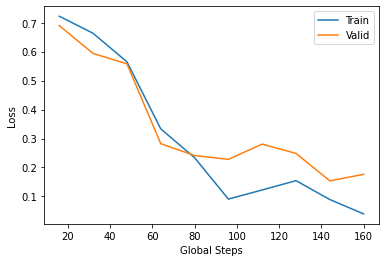

In [ ]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

# Evaluation

For evaluating the final accuracy of the best model, we use the best traind model to make prediction for the test data, then we compare the predicted values by the model to the actual labels of the test data and report the result of this comparison. 

In [ ]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, title, text, titletext), _ in test_loader:

                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                titletext = titletext.type(torch.LongTensor)  
                titletext = titletext.to(device)
                output = model(titletext, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

In [ ]:
y_pred = []
y_true = []
with torch.no_grad():
      for (label, title, text, titletext), _ in test_iter:

              #print(lable)
              label = label.type(torch.LongTensor)           
              label = label.to(device)
              titletext = titletext.type(torch.LongTensor)  
              titletext = titletext.to(device)
              output = model(titletext, label)

              _, output = output
              y_pred.extend(torch.argmax(output, 1).tolist())
              y_true.extend(label.tolist())


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/Data/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.9705    0.8874    0.9271      2816
           0     0.8976    0.9734    0.9339      2854

    accuracy                         0.9307      5670
   macro avg     0.9340    0.9304    0.9305      5670
weighted avg     0.9338    0.9307    0.9305      5670



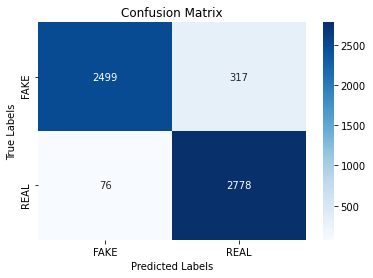

In [ ]:
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)